In [1]:
import pandas as pd
import numpy as np
import ast
import pickle
import csv
import os
from pathlib import Path
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
import seaborn as sns
import spikeanal as spike

# It takes several steps to create the timestamp_dicts, refer to Ephys_Analysis_Notebook to create
timestamp_dicts = pickle.load(open('hpc_timestamp_dicts.pkl', 'rb'))

# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'non-novel' / 'all_non_novel'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-1_t1b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-4_t4b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec
<class

In [2]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


In [3]:
# Create df of spike freq 10s before and 10s during every event
event_spikes = spike_analysis.generate_event_dataframe()

# Identify 'Pre-event' and 'Event' columns
pre_event_cols = [col for col in event_spikes.columns if col.startswith('Pre-event')]
event_cols = [col for col in event_spikes.columns if col.startswith('Event') and col not in ['Event name', 'Event number']]

event_spikes

,Recording,Event name,Event number,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,...,Event timebin 91,Event timebin 92,Event timebin 93,Event timebin 94,Event timebin 95,Event timebin 96,Event timebin 97,Event timebin 98,Event timebin 99,Event timebin 100
0,20230612_101430_standard_comp_to_training_D1_s...,rewarded,1,85,1.28,1.28,1.28,1.28,1.28,1.28,...,0.76,0.76,0.76,0.76,0.76,0.72,0.72,0.72,0.72,0.72
1,20230612_101430_standard_comp_to_training_D1_s...,rewarded,2,85,0.12,0.12,0.12,0.12,0.12,0.12,...,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24
2,20230612_101430_standard_comp_to_training_D1_s...,rewarded,3,85,0.12,0.12,0.12,0.12,0.12,0.12,...,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12
3,20230612_101430_standard_comp_to_training_D1_s...,rewarded,4,85,0.24,0.24,0.24,0.24,0.24,0.24,...,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12
4,20230612_101430_standard_comp_to_training_D1_s...,rewarded,5,85,0.20,0.20,0.20,0.20,0.20,0.20,...,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10015,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,16,11,0.76,0.76,0.76,0.72,0.72,0.72,...,0.48,0.48,0.48,0.44,0.44,0.44,0.44,0.44,0.44,0.44
10016,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,17,11,0.16,0.16,0.16,0.16,0.16,0.16,...,0.84,0.92,0.92,0.96,0.96,1.00,1.00,1.00,1.00,1.00
10017,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,18,11,0.08,0.08,0.08,0.08,0.08,0.08,...,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24
10018,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,19,11,0.04,0.04,0.04,0.04,0.04,0.04,...,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36


In [5]:
event_spikes['Unit number'].value_counts()

Unit number
17     242
39     199
15     197
48     196
52     162
      ... 
114     21
72      21
95      21
34      21
4       21
Name: count, Length: 142, dtype: int64

In [36]:
event_spikes['Event name'].value_counts()

Event name
lose             2854
win              2746
both_rewarded    2381
rewarded         1752
omission          287
Name: count, dtype: int64

In [7]:
recording1 = event_spikes[event_spikes['Recording'] == '20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec']

In [8]:
recording1

,Recording,Event name,Event number,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,...,Event timebin 91,Event timebin 92,Event timebin 93,Event timebin 94,Event timebin 95,Event timebin 96,Event timebin 97,Event timebin 98,Event timebin 99,Event timebin 100
0,20230612_101430_standard_comp_to_training_D1_s...,rewarded,1,85,1.28,1.28,1.28,1.28,1.28,1.28,...,0.76,0.76,0.76,0.76,0.76,0.72,0.72,0.72,0.72,0.72
1,20230612_101430_standard_comp_to_training_D1_s...,rewarded,2,85,0.12,0.12,0.12,0.12,0.12,0.12,...,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24
2,20230612_101430_standard_comp_to_training_D1_s...,rewarded,3,85,0.12,0.12,0.12,0.12,0.12,0.12,...,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12
3,20230612_101430_standard_comp_to_training_D1_s...,rewarded,4,85,0.24,0.24,0.24,0.24,0.24,0.24,...,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12
4,20230612_101430_standard_comp_to_training_D1_s...,rewarded,5,85,0.20,0.20,0.20,0.20,0.20,0.20,...,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,20230612_101430_standard_comp_to_training_D1_s...,lose,3,57,0.04,0.04,0.04,0.04,0.04,0.04,...,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12
756,20230612_101430_standard_comp_to_training_D1_s...,lose,4,57,0.04,0.04,0.04,0.04,0.04,0.04,...,0.00,0.00,0.00,0.00,0.00,0.04,0.04,0.04,0.04,0.04
757,20230612_101430_standard_comp_to_training_D1_s...,lose,5,57,0.00,0.00,0.00,0.00,0.00,0.00,...,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04
758,20230612_101430_standard_comp_to_training_D1_s...,lose,6,57,0.08,0.08,0.08,0.08,0.08,0.08,...,0.16,0.16,0.16,0.16,0.16,0.16,0.16,0.16,0.16,0.16


In [9]:
recording1['Unit number'].value_counts()

Unit number
85    40
13    40
36    40
5     40
26    40
88    40
19    40
81    40
59    40
33    40
55    40
2     40
94    40
98    40
65    40
68    40
24    40
17    40
57    40
Name: count, dtype: int64

In [10]:
# Assuming event_spikes is your DataFrame
groups = recording1.groupby(['Unit number', 'Event name'])

# Prepare dictionaries to store the results
pre_event_arrays = {}
event_arrays = {}

# Iterate through each group
for (unit, event_name), group in groups:
    # Sort the group by 'Event number' to ensure correct order
    sorted_group = group.sort_values('Event number')
    
    # Concatenate pre-event and event columns across all event numbers for this group
    pre_event_data = np.concatenate([sorted_group[pre_event_cols].values.flatten()])
    event_data = np.concatenate([sorted_group[event_cols].values.flatten()])
    
    # Store in dictionaries
    pre_event_arrays[f'pre_{event_name}_{unit}'] = pre_event_data
    event_arrays[f'during_{event_name}_{unit}'] = event_data

In [12]:
pre_event_arrays.keys()

dict_keys(['pre_lose_2', 'pre_rewarded_2', 'pre_win_2', 'pre_lose_5', 'pre_rewarded_5', 'pre_win_5', 'pre_lose_13', 'pre_rewarded_13', 'pre_win_13', 'pre_lose_17', 'pre_rewarded_17', 'pre_win_17', 'pre_lose_19', 'pre_rewarded_19', 'pre_win_19', 'pre_lose_24', 'pre_rewarded_24', 'pre_win_24', 'pre_lose_26', 'pre_rewarded_26', 'pre_win_26', 'pre_lose_33', 'pre_rewarded_33', 'pre_win_33', 'pre_lose_36', 'pre_rewarded_36', 'pre_win_36', 'pre_lose_55', 'pre_rewarded_55', 'pre_win_55', 'pre_lose_57', 'pre_rewarded_57', 'pre_win_57', 'pre_lose_59', 'pre_rewarded_59', 'pre_win_59', 'pre_lose_65', 'pre_rewarded_65', 'pre_win_65', 'pre_lose_68', 'pre_rewarded_68', 'pre_win_68', 'pre_lose_81', 'pre_rewarded_81', 'pre_win_81', 'pre_lose_85', 'pre_rewarded_85', 'pre_win_85', 'pre_lose_88', 'pre_rewarded_88', 'pre_win_88', 'pre_lose_94', 'pre_rewarded_94', 'pre_win_94', 'pre_lose_98', 'pre_rewarded_98', 'pre_win_98'])

In [13]:
event_arrays.keys()

dict_keys(['during_lose_2', 'during_rewarded_2', 'during_win_2', 'during_lose_5', 'during_rewarded_5', 'during_win_5', 'during_lose_13', 'during_rewarded_13', 'during_win_13', 'during_lose_17', 'during_rewarded_17', 'during_win_17', 'during_lose_19', 'during_rewarded_19', 'during_win_19', 'during_lose_24', 'during_rewarded_24', 'during_win_24', 'during_lose_26', 'during_rewarded_26', 'during_win_26', 'during_lose_33', 'during_rewarded_33', 'during_win_33', 'during_lose_36', 'during_rewarded_36', 'during_win_36', 'during_lose_55', 'during_rewarded_55', 'during_win_55', 'during_lose_57', 'during_rewarded_57', 'during_win_57', 'during_lose_59', 'during_rewarded_59', 'during_win_59', 'during_lose_65', 'during_rewarded_65', 'during_win_65', 'during_lose_68', 'during_rewarded_68', 'during_win_68', 'during_lose_81', 'during_rewarded_81', 'during_win_81', 'during_lose_85', 'during_rewarded_85', 'during_win_85', 'during_lose_88', 'during_rewarded_88', 'during_win_88', 'during_lose_94', 'during_

In [15]:
from scipy.stats import wilcoxon

# Initialize DataFrame
result_columns = ['unit', 'win', 'lose', 'rewarded']
recording1_wilcox_results = pd.DataFrame(columns=result_columns)

# List of units and events to process
units = set(k.split('_')[-1] for k in pre_event_arrays.keys())
events = ['win', 'lose', 'rewarded']

# Helper function to analyze results
def analyze_results(pre_data, event_data):
    stat, p_value = wilcoxon(pre_data, event_data)
    if p_value > 0.05:
        return 'not significant'
    else:
        return 'increase' if event_data.mean() > pre_data.mean() else 'decrease'

# Process each unit
for unit in units:
    result_row = {'unit': unit}
    for event in events:
        pre_key = f'pre_{event}_{unit}'
        event_key = f'during_{event}_{unit}'
        if pre_key in pre_event_arrays and event_key in event_arrays:
            result = analyze_results(pre_event_arrays[pre_key], event_arrays[event_key])
            result_row[event] = result
        else:
            result_row[event] = 'not significant'  # Default if no data available
    # Use concat instead of append
    recording1_wilcox_results = pd.concat([recording1_wilcox_results, pd.DataFrame([result_row])], ignore_index=True)

recording1_wilcox_results

,unit,win,lose,rewarded
0,33,not significant,increase,increase
1,19,increase,decrease,decrease
2,98,decrease,not significant,decrease
3,24,decrease,not significant,decrease
4,88,decrease,decrease,increase
5,85,decrease,decrease,decrease
6,68,increase,decrease,decrease
7,81,decrease,decrease,decrease
8,13,increase,increase,increase
9,2,decrease,decrease,decrease


In [23]:
analyze_results(pre_lose_2, pre_rewarded_2_cut)

'decrease'

In [19]:
len(pre_event_arrays['pre_lose_2'])

700

In [20]:
len(pre_event_arrays['pre_rewarded_2'])

2000

In [21]:
pre_lose_2 = pre_event_arrays['pre_lose_2']
pre_rewarded_2_cut = pre_event_arrays['pre_rewarded_2'][:700]

In [22]:
len(pre_rewarded_2_cut)

700

In [24]:
from scipy.stats import wilcoxon
import pandas as pd

# Initialize DataFrame with additional columns for p-values
result_columns = ['unit', 'win', 'lose', 'rewarded', 'win p-value', 'lose p-value', 'rewarded p-value']
recording1_wilcox_results = pd.DataFrame(columns=result_columns)

# List of units and events to process
units = set(k.split('_')[-1] for k in pre_event_arrays.keys())
events = ['win', 'lose', 'rewarded']

# Helper function to analyze results and return both result and p-value
def analyze_results(pre_data, event_data):
    stat, p_value = wilcoxon(pre_data, event_data)
    result = 'not significant' if p_value > 0.05 else ('increase' if event_data.mean() > pre_data.mean() else 'decrease')
    return result, p_value

# Process each unit
for unit in units:
    result_row = {'unit': unit}
    for event in events:
        pre_key = f'pre_{event}_{unit}'
        event_key = f'during_{event}_{unit}'
        if pre_key in pre_event_arrays and event_key in event_arrays:
            result, p_value = analyze_results(pre_event_arrays[pre_key], event_arrays[event_key])
            result_row[event] = result
            result_row[f'{event} p-value'] = p_value
        else:
            result_row[event] = 'not significant'  # Default result if no data available
            result_row[f'{event} p-value'] = None  # Default p-value if no data available

    # Append the row for the current unit to the DataFrame using concat
    recording1_wilcox_results = pd.concat([recording1_wilcox_results, pd.DataFrame([result_row])], ignore_index=True)

recording1_wilcox_results

C:\Users\short\AppData\Local\Temp\ipykernel_18808\1856027074.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  recording1_wilcox_results = pd.concat([recording1_wilcox_results, pd.DataFrame([result_row])], ignore_index=True)


,unit,win,lose,rewarded,win p-value,lose p-value,rewarded p-value
0,33,not significant,increase,increase,5.340951e-01,4.892402e-30,3.328270e-114
1,19,increase,decrease,decrease,4.423026e-69,1.913132e-28,1.125846e-51
2,98,decrease,not significant,decrease,3.436997e-55,8.167019e-01,2.474619e-126
3,24,decrease,not significant,decrease,4.810146e-117,4.463507e-01,6.738827e-234
4,88,decrease,decrease,increase,1.156740e-33,4.139362e-05,2.376798e-14
5,85,decrease,decrease,decrease,5.594988e-16,1.457667e-73,3.680499e-41
6,68,increase,decrease,decrease,1.370684e-41,1.964138e-06,2.021449e-06
7,81,decrease,decrease,decrease,1.884757e-04,2.973070e-09,3.301511e-76
8,13,increase,increase,increase,8.536939e-76,1.091698e-42,6.158401e-238
9,2,decrease,decrease,decrease,4.148925e-96,2.985492e-22,1.324785e-25


In [25]:
np.mean(recording1_wilcox_results['win p-value'])

0.028120189534160102

In [26]:
np.mean(recording1_wilcox_results['lose p-value'])

0.16559417347591934

In [27]:
np.mean(recording1_wilcox_results['rewarded p-value'])

0.005793924302529586

In [28]:
np.sum(recording1_wilcox_results['lose p-value'])

3.1462892960424678

In [29]:
3.146/18

0.17477777777777778

In [38]:
recording2 = event_spikes[event_spikes['Recording'] == '20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged.rec']

In [39]:
# Assuming event_spikes is your DataFrame
groups = recording2.groupby(['Unit number', 'Event name'])

# Prepare dictionaries to store the results
pre_event_arrays = {}
event_arrays = {}

# Iterate through each group
for (unit, event_name), group in groups:
    # Sort the group by 'Event number' to ensure correct order
    sorted_group = group.sort_values('Event number')
    
    # Concatenate pre-event and event columns across all event numbers for this group
    pre_event_data = np.concatenate([sorted_group[pre_event_cols].values.flatten()])
    event_data = np.concatenate([sorted_group[event_cols].values.flatten()])
    
    # Store in dictionaries
    pre_event_arrays[f'pre_{event_name}_{unit}'] = pre_event_data
    event_arrays[f'during_{event_name}_{unit}'] = event_data

In [40]:
# Initialize DataFrame with additional columns for p-values
result_columns = ['unit', 'win', 'lose', 'rewarded', 'win p-value', 'lose p-value', 'rewarded p-value']
recording2_wilcox_results = pd.DataFrame(columns=result_columns)

# List of units and events to process
units = set(k.split('_')[-1] for k in pre_event_arrays.keys())
events = ['win', 'lose', 'rewarded']

# Process each unit
for unit in units:
    result_row = {'unit': unit}
    for event in events:
        pre_key = f'pre_{event}_{unit}'
        event_key = f'during_{event}_{unit}'
        if pre_key in pre_event_arrays and event_key in event_arrays:
            result, p_value = analyze_results(pre_event_arrays[pre_key], event_arrays[event_key])
            result_row[event] = result
            result_row[f'{event} p-value'] = p_value
        else:
            result_row[event] = 'not significant'  # Default result if no data available
            result_row[f'{event} p-value'] = None  # Default p-value if no data available

    # Append the row for the current unit to the DataFrame using concat
    recording2_wilcox_results = pd.concat([recording2_wilcox_results, pd.DataFrame([result_row])], ignore_index=True)

recording2_wilcox_results

C:\Users\short\AppData\Local\Temp\ipykernel_18808\950216315.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  recording2_wilcox_results = pd.concat([recording2_wilcox_results, pd.DataFrame([result_row])], ignore_index=True)


,unit,win,lose,rewarded,win p-value,lose p-value,rewarded p-value
0,74,increase,decrease,increase,5.612036e-21,2.208537e-133,1.406254e-165
1,15,increase,increase,increase,3.559529e-33,1.021333e-30,2.369683e-03
2,37,increase,decrease,decrease,2.103646e-33,1.021854e-06,8.834704e-72
3,82,increase,increase,increase,1.316371e-34,1.795649e-278,2.414928e-75
4,87,increase,increase,increase,1.101864e-34,3.457421e-277,9.553979e-261
5,46,increase,increase,not significant,1.414243e-34,1.759110e-43,7.935557e-02
6,16,decrease,not significant,decrease,1.186619e-03,3.263672e-01,3.943141e-234
7,47,increase,increase,decrease,2.771983e-20,1.110119e-130,2.039556e-236
8,76,increase,decrease,decrease,5.586794e-24,2.252855e-33,4.342802e-156
9,89,decrease,decrease,decrease,1.403898e-34,3.508765e-220,1.013101e-243


In [41]:
np.mean(recording2_wilcox_results['win p-value'])

6.639390473172176e-05

In [42]:
np.mean(recording2_wilcox_results['lose p-value'])

0.033837255781060324

In [43]:
np.mean(recording2_wilcox_results['rewarded p-value'])

0.050617625038462156

In [44]:
recording3 = event_spikes[event_spikes['Recording'] == '20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-1_t1b2L_box1_merged.rec']

# Assuming event_spikes is your DataFrame
groups = recording3.groupby(['Unit number', 'Event name'])

# Prepare dictionaries to store the results
pre_event_arrays = {}
event_arrays = {}

# Iterate through each group
for (unit, event_name), group in groups:
    # Sort the group by 'Event number' to ensure correct order
    sorted_group = group.sort_values('Event number')
    
    # Concatenate pre-event and event columns across all event numbers for this group
    pre_event_data = np.concatenate([sorted_group[pre_event_cols].values.flatten()])
    event_data = np.concatenate([sorted_group[event_cols].values.flatten()])
    
    # Store in dictionaries
    pre_event_arrays[f'pre_{event_name}_{unit}'] = pre_event_data
    event_arrays[f'during_{event_name}_{unit}'] = event_data

# Initialize DataFrame with additional columns for p-values
result_columns = ['unit', 'win', 'lose', 'both_rewarded', 'win p-value', 'lose p-value', 'both_rewarded p-value']
recording3_wilcox_results = pd.DataFrame(columns=result_columns)

# List of units and events to process
units = set(k.split('_')[-1] for k in pre_event_arrays.keys())
events = ['win', 'lose', 'both_rewarded']

# Helper function to analyze results and return both result and p-value
def analyze_results(pre_data, event_data):
    stat, p_value = wilcoxon(pre_data, event_data)
    result = 'not significant' if p_value > 0.01 else ('increase' if event_data.mean() > pre_data.mean() else 'decrease')
    return result, p_value

# Process each unit
for unit in units:
    result_row = {'unit': unit}
    for event in events:
        pre_key = f'pre_{event}_{unit}'
        event_key = f'during_{event}_{unit}'
        if pre_key in pre_event_arrays and event_key in event_arrays:
            result, p_value = analyze_results(pre_event_arrays[pre_key], event_arrays[event_key])
            result_row[event] = result
            result_row[f'{event} p-value'] = p_value
        else:
            result_row[event] = 'not significant'  # Default result if no data available
            result_row[f'{event} p-value'] = None  # Default p-value if no data available

    # Append the row for the current unit to the DataFrame using concat
    recording3_wilcox_results = pd.concat([recording3_wilcox_results, pd.DataFrame([result_row])], ignore_index=True)

recording3_wilcox_results

C:\Users\short\AppData\Local\Temp\ipykernel_18808\175748976.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  recording3_wilcox_results = pd.concat([recording3_wilcox_results, pd.DataFrame([result_row])], ignore_index=True)


,unit,win,lose,both_rewarded,win p-value,lose p-value,both_rewarded p-value
0,60,increase,decrease,increase,1.568099e-03,9.957702e-43,1.547778e-03
1,25,decrease,decrease,not significant,1.314797e-16,1.665023e-22,4.856439e-01
2,81,increase,increase,not significant,7.701904e-20,1.472848e-15,2.453721e-02
3,7,decrease,not significant,decrease,2.957198e-25,2.409781e-01,1.243603e-163
4,3,decrease,decrease,decrease,7.136859e-16,2.151280e-37,1.041860e-71
5,13,decrease,decrease,decrease,2.381965e-73,1.062486e-41,1.815963e-125
6,78,increase,decrease,decrease,4.294421e-22,3.343236e-22,1.006638e-37
7,32,increase,increase,increase,4.666630e-05,7.954496e-11,5.863089e-50
8,67,increase,decrease,decrease,1.827172e-04,1.072463e-09,4.545812e-75
9,62,decrease,not significant,decrease,4.104372e-132,5.873732e-01,4.247315e-268


In [45]:
np.mean(recording3_wilcox_results['win p-value'])

0.0001125449063015995

In [46]:
np.mean(recording3_wilcox_results['lose p-value'])

0.05366347606045844

In [48]:
np.mean(recording3_wilcox_results['both_rewarded p-value'])

0.03198305350287264

In [49]:
arraya = [1,2,3,4]
arrayb = [5,6,7,8]
test_stat, test_p_value = wilcoxon(arraya, arrayb)

In [50]:
test_p_value

0.125

In [51]:
arraya = [1,2,3,4]
arrayb = [20,20,20,20]
test_stat, test_p_value = wilcoxon(arraya, arrayb)

In [52]:
test_p_value

0.125

In [54]:
arraya = [1,2,3,4]
arrayb = [2,1,4,5]
test_stat, test_p_value = wilcoxon(arraya, arrayb)

In [55]:
test_p_value

0.375

In [56]:
arrayb = [1,2,3,4]
arraya = [20,20,20,20]
test_stat, test_p_value = wilcoxon(arraya, arrayb)

In [57]:
test_p_value

0.125

In [58]:
event_spikes

,Recording,Event name,Event number,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,...,Event timebin 91,Event timebin 92,Event timebin 93,Event timebin 94,Event timebin 95,Event timebin 96,Event timebin 97,Event timebin 98,Event timebin 99,Event timebin 100
0,20230612_101430_standard_comp_to_training_D1_s...,rewarded,1,85,1.28,1.28,1.28,1.28,1.28,1.28,...,0.76,0.76,0.76,0.76,0.76,0.72,0.72,0.72,0.72,0.72
1,20230612_101430_standard_comp_to_training_D1_s...,rewarded,2,85,0.12,0.12,0.12,0.12,0.12,0.12,...,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24
2,20230612_101430_standard_comp_to_training_D1_s...,rewarded,3,85,0.12,0.12,0.12,0.12,0.12,0.12,...,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12
3,20230612_101430_standard_comp_to_training_D1_s...,rewarded,4,85,0.24,0.24,0.24,0.24,0.24,0.24,...,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12
4,20230612_101430_standard_comp_to_training_D1_s...,rewarded,5,85,0.20,0.20,0.20,0.20,0.20,0.20,...,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10015,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,16,11,0.76,0.76,0.76,0.72,0.72,0.72,...,0.48,0.48,0.48,0.44,0.44,0.44,0.44,0.44,0.44,0.44
10016,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,17,11,0.16,0.16,0.16,0.16,0.16,0.16,...,0.84,0.92,0.92,0.96,0.96,1.00,1.00,1.00,1.00,1.00
10017,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,18,11,0.08,0.08,0.08,0.08,0.08,0.08,...,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24
10018,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,19,11,0.04,0.04,0.04,0.04,0.04,0.04,...,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36


In [60]:
from scipy.stats import wilcoxon
import pandas as pd
import numpy as np

# Define a function to perform the Wilcoxon signed-rank test safely
def perform_wilcoxon(row):
    pre_event_values = row[pre_event_cols].values
    event_values = row[event_cols].values
    # Check if all differences are zero
    if np.all(pre_event_values == event_values):
        return np.nan  # Return NaN if no variation to avoid ValueError
    else:
        # Perform the Wilcoxon signed-rank test
        stat, p_value = wilcoxon(pre_event_values, event_values)
        return p_value

# Apply the test across rows
event_spikes['Wilcox p-value'] = event_spikes.apply(perform_wilcoxon, axis=1)

# Handle potential warnings or errors gracefully
try:
    mean_p_value = np.nanmean(event_spikes['Wilcox p-value'])  # Calculate mean, ignoring NaNs
    print(f"Mean p-value: {mean_p_value}")
except Exception as e:
    print(f"An error occurred: {e}")

# Check if all p-values are NaN
if event_spikes['Wilcox p-value'].isna().all():
    print("No valid Wilcoxon tests were performed due to data issues such as non-variability.")
else:
    # Display the results
    print(event_spikes[['Recording', 'Event name', 'Wilcox p-value']])

C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal ap

Mean p-value: 0.028560532356265725
                                               Recording     Event name  \
0      20230612_101430_standard_comp_to_training_D1_s...       rewarded   
1      20230612_101430_standard_comp_to_training_D1_s...       rewarded   
2      20230612_101430_standard_comp_to_training_D1_s...       rewarded   
3      20230612_101430_standard_comp_to_training_D1_s...       rewarded   
4      20230612_101430_standard_comp_to_training_D1_s...       rewarded   
...                                                  ...            ...   
10015  20230625_112913_standard_comp_to_both_rewarded...  both_rewarded   
10016  20230625_112913_standard_comp_to_both_rewarded...  both_rewarded   
10017  20230625_112913_standard_comp_to_both_rewarded...  both_rewarded   
10018  20230625_112913_standard_comp_to_both_rewarded...  both_rewarded   
10019  20230625_112913_standard_comp_to_both_rewarded...  both_rewarded   

       Wilcox p-value  
0        5.894376e-17  
1        5.32890

In [61]:
event_spikes

,Recording,Event name,Event number,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,...,Event timebin 92,Event timebin 93,Event timebin 94,Event timebin 95,Event timebin 96,Event timebin 97,Event timebin 98,Event timebin 99,Event timebin 100,Wilcox p-value
0,20230612_101430_standard_comp_to_training_D1_s...,rewarded,1,85,1.28,1.28,1.28,1.28,1.28,1.28,...,0.76,0.76,0.76,0.76,0.72,0.72,0.72,0.72,0.72,5.894376e-17
1,20230612_101430_standard_comp_to_training_D1_s...,rewarded,2,85,0.12,0.12,0.12,0.12,0.12,0.12,...,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,5.328905e-01
2,20230612_101430_standard_comp_to_training_D1_s...,rewarded,3,85,0.12,0.12,0.12,0.12,0.12,0.12,...,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,2.427184e-06
3,20230612_101430_standard_comp_to_training_D1_s...,rewarded,4,85,0.24,0.24,0.24,0.24,0.24,0.24,...,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,2.784046e-12
4,20230612_101430_standard_comp_to_training_D1_s...,rewarded,5,85,0.20,0.20,0.20,0.20,0.20,0.20,...,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,2.483787e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10015,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,16,11,0.76,0.76,0.76,0.72,0.72,0.72,...,0.48,0.48,0.44,0.44,0.44,0.44,0.44,0.44,0.44,5.085894e-01
10016,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,17,11,0.16,0.16,0.16,0.16,0.16,0.16,...,0.92,0.92,0.96,0.96,1.00,1.00,1.00,1.00,1.00,2.821209e-11
10017,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,18,11,0.08,0.08,0.08,0.08,0.08,0.08,...,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,4.497555e-18
10018,20230625_112913_standard_comp_to_both_rewarded...,both_rewarded,19,11,0.04,0.04,0.04,0.04,0.04,0.04,...,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,1.201427e-18


In [64]:
event_spikes['Wilcox p-value'].isna().sum()

16

In [66]:
from scipy.stats import combine_pvalues

grouped = event_spikes.groupby(['Recording', 'Event name', 'Unit number'])

# Define a function to apply Fisher's method
def fishers_method(group):
    p_values = group['Wilcox p-value'].dropna().tolist()  # Ensure no NaN values are included
    if p_values:  # Check if the list is not empty
        stat, combined_p_value = combine_pvalues(p_values, method='fisher')
        return combined_p_value
    else:
        return None  # In case there are no p-values to combine

# Apply the function to each group and reset index
result_df = grouped.apply(fishers_method).reset_index(name='Combined Wilcox p-value')

In [67]:
result_df

,Recording,Event name,Unit number,Combined Wilcox p-value
0,20230612_101430_standard_comp_to_training_D1_s...,lose,2,1.533256e-88
1,20230612_101430_standard_comp_to_training_D1_s...,lose,5,2.211878e-90
2,20230612_101430_standard_comp_to_training_D1_s...,lose,13,6.077073e-96
3,20230612_101430_standard_comp_to_training_D1_s...,lose,17,4.164274e-70
4,20230612_101430_standard_comp_to_training_D1_s...,lose,19,1.466932e-83
...,...,...,...,...
797,20230625_112913_standard_comp_to_both_rewarded...,win,60,5.083878e-63
798,20230625_112913_standard_comp_to_both_rewarded...,win,77,1.000505e-63
799,20230625_112913_standard_comp_to_both_rewarded...,win,85,1.444974e-54
800,20230625_112913_standard_comp_to_both_rewarded...,win,99,2.803916e-42


In [68]:
np.mean(result_df['Combined Wilcox p-value'])

0.00017443073740476084

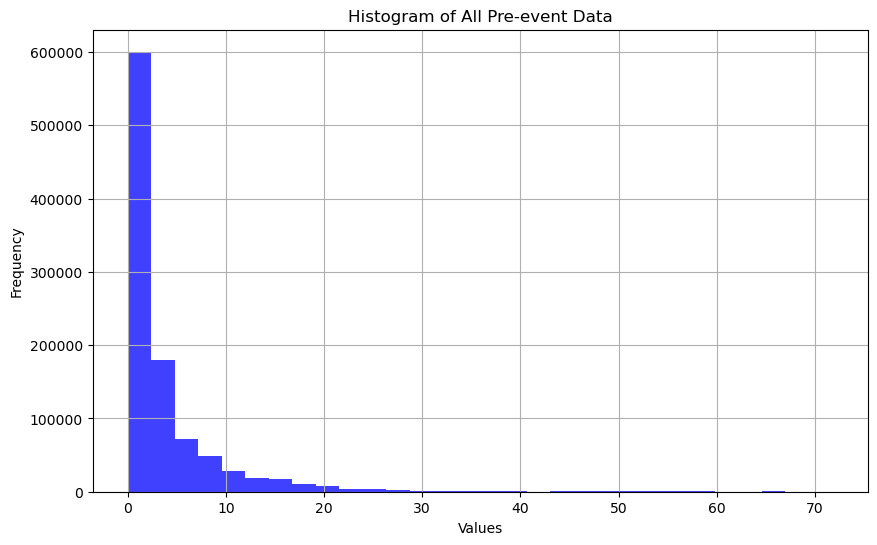

In [69]:
# Concatenate all pre-event data into a single Series for histogram plotting
all_pre_event_data = pd.concat([event_spikes[col] for col in pre_event_cols], axis=0)

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(all_pre_event_data, bins=30, alpha=0.75, color='blue')
plt.title('Histogram of All Pre-event Data')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

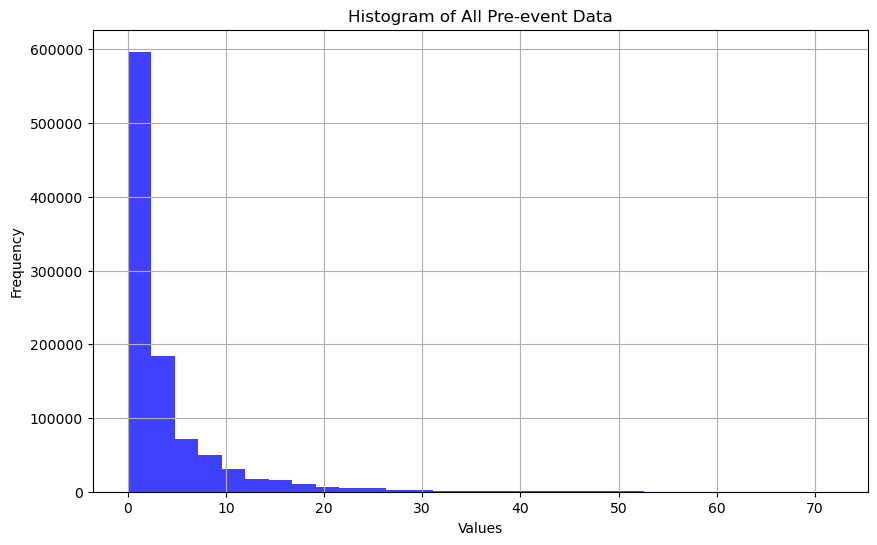

In [70]:
# Concatenate all pre-event data into a single Series for histogram plotting
all_event_data = pd.concat([event_spikes[col] for col in event_cols], axis=0)

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(all_event_data, bins=30, alpha=0.75, color='blue')
plt.title('Histogram of All Pre-event Data')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [73]:
recording1.get_spike_specs

AttributeError: 'DataFrame' object has no attribute 'get_spike_specs'

In [75]:
recordings = spike_analysis.ephyscollection.collection
recording_name = '20230618_100636_standard_comp_to_omission_D2_subj_1-4_t4b3L_box1_merged.rec'
recording1 = recordings.get(recording_name)

recording1.get_spike_specs

<bound method EphysRecording.get_spike_specs of <spikeanal.EphysRecording object at 0x000001FC24648650>>

In [77]:
recording1.unit_spiketrains

{65: array([2, 2, 0, ..., 0, 0, 0], dtype=int64),
 123: array([2, 0, 0, ..., 0, 0, 0], dtype=int64),
 103: array([2, 2, 1, ..., 1, 0, 1], dtype=int64),
 83: array([0, 1, 1, ..., 1, 3, 1], dtype=int64),
 118: array([0, 1, 0, ..., 0, 0, 0], dtype=int64),
 93: array([0, 0, 0, ..., 1, 0, 1], dtype=int64),
 99: array([0, 0, 0, ..., 1, 1, 1], dtype=int64),
 105: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 87: array([0, 0, 0, ..., 0, 1, 0], dtype=int64),
 19: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 9: array([0, 0, 0, ..., 0, 0, 0], dtype=int64)}

In [78]:
len(recording1.unit_spiketrains[65])

33549

In [79]:
len(recording1.unit_spiketrains[123])

33549

In [81]:
spike_analysis.__get_event_snippets__(recording=recording1, event='win')

TypeError: SpikeAnalysis_MultiRecording.__get_event_snippets__() missing 2 required positional arguments: 'whole_recording' and 'equalize'

In [84]:
print(dir(spike_analysis))

['LOO_PCA', 'PCA_matrix', 'PCA_matrix_generation', 'PCA_trajectories', '__PCA_EDA_plot_3D__', '__PCA_EDA_plot__', '__PCA_for_decoding__', '__all_set__', '__calc_preevent_baseline__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__event_baseline__', '__format__', '__ge__', '__get_event_firing_rates__', '__get_event_snippets__', '__get_unit_event_firing_rates__', '__get_unit_firing_rates__', '__get_unit_spiketrains__', '__get_whole_spiketrain__', '__getattribute__', '__getstate__', '__global_baseline__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__make_zscore_df__', '__module__', '__ne__', '__new__', '__plot_auc__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '__wilcox_baseline_v_event_plots__', '__wilcox_baseline_v_event_stats__', '__wilcox_event_v_event_plots__', '__wilcoxon_event_v_event_stats__', '__zscore_event2__', '__zscore_event__', '__zscore_plo

In [88]:
print(dir(spike_analysis.ephyscollection.collection))

['__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__or__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'clear', 'copy', 'fromkeys', 'get', 'items', 'keys', 'pop', 'popitem', 'setdefault', 'update', 'values']


In [89]:
spike_analysis.ephyscollection.collection.keys()

dict_keys(['20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec', '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec', '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec', '20230618_100636_standard_comp_to_omission_D2_subj_1-1_t1b2L_box2_merged.rec', '20230618_100636_standard_comp_to_omission_D2_subj_1-4_t4b3L_box1_merged.rec', '20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.rec', '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec', '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec', '20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged.rec', '20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec', '20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-2_t3b3L_box1_merged.rec', '20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-2_t1b2L_box1_merged.rec', '20230624_105855_standar

In [92]:
print(dir(spike_analysis.ephyscollection.collection['20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec']))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'event_dict', 'freq_dict', 'get_spike_specs', 'get_unit_labels', 'get_unit_timestamps', 'labels_dict', 'path', 'sampling_rate', 'spiketrain', 'subject', 'timestamps_var', 'unit_array', 'unit_firing_rate_array', 'unit_firing_rates', 'unit_spiketrains', 'unit_timestamps', 'wilcox_dfs', 'zscored_events']


In [93]:
spike_analysis.ephyscollection.collection['20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec'].unit_spiketrains          

{85: array([1, 1, 0, ..., 0, 0, 0], dtype=int64),
 55: array([1, 0, 1, ..., 1, 1, 1], dtype=int64),
 17: array([0, 1, 2, ..., 1, 0, 0], dtype=int64),
 24: array([0, 1, 1, ..., 0, 0, 0], dtype=int64),
 68: array([0, 0, 1, ..., 0, 0, 0], dtype=int64),
 65: array([0, 0, 1, ..., 0, 0, 0], dtype=int64),
 98: array([0, 0, 1, ..., 0, 0, 0], dtype=int64),
 94: array([0, 0, 1, ..., 0, 0, 0], dtype=int64),
 2: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 33: array([0, 0, 0, ..., 0, 0, 1], dtype=int64),
 13: array([0, 0, 0, ..., 1, 1, 0], dtype=int64),
 59: array([0, 0, 0, ..., 0, 0, 1], dtype=int64),
 81: array([0, 0, 0, ..., 0, 1, 0], dtype=int64),
 19: array([0, 0, 0, ..., 1, 1, 0], dtype=int64),
 88: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 26: array([0, 0, 0, ..., 1, 1, 0], dtype=int64),
 5: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 36: array([0, 0, 0, ..., 1, 2, 2], dtype=int64),
 57: array([0, 0, 0, ..., 0, 0, 0], dtype=int64)}

In [ ]:
for unit in recording1.unit_firing_rates.keys():
    unit_event_firing_rates[unit] = self.__get_event_snippets__(recording, event, recording.unit_firing_rates[unit], equalize, pre_window, post_window)

In [98]:
for unit in recording1.unit_firing_rates.keys():
    unit_event_firing_rates[unit] = spike_analysis.__get_event_snippets__(recording, event='win', recording1.unit_firing_rates[unit], equalize=10, pre_window=0, post_window=0)

SyntaxError: positional argument follows keyword argument (3180436080.py, line 2)

In [ ]:
spike_analysis.__get_event_snippets__(recording1, event, recording.unit_firing_rates[unit], equalize, pre_window, post_window)


In [103]:
def __get_event_snippets__(recording, event, whole_recording, equalize, pre_window=0, post_window=0):
    """
    takes snippets of spiketrains or firing rates for events
    optional pre-event and post-event windows (s) may be included
    all events can also be of equal length by extending
    snippet lengths to the longest event

    Args (6 total, 4 required):
        recording: EphysRecording instance, recording to get snippets
        event: str, event type of which ehpys snippets happen during
        whole_recording: numpy array, spiketrain or firing rates
            for the whole recording, for population or for a single unit
        equalize: float, length (s) of events used by padding with post
            event time or trimming events all to equalize (s) long
        pre_window: int, default=0, seconds prior to start of event
        post_window: int, default=0, seconds after end of event
        
    Returns (1):
        event_snippets: a list of lists, where each list is a list of
            firing rates or spiketrains during an event including 
            pre_window & post_windows, accounting for equalize and 
            timebins for a single unit or for the population returning
            a list of numpy arrays
    """
    if type(event) is str:
        events = recording.event_dict[event]
    else:
        events = event
    event_snippets = []
    pre_window = math.ceil(pre_window * 1000)
    post_window = math.ceil(post_window * 1000)
    equalize = equalize * 1000
    e_length = equalize + post_window + pre_window
    for i in range(events.shape[0]):
        pre_event = math.ceil((events[i][0] - pre_window) / timebin)
        post_event = math.ceil(
            (events[i][0] + post_window + equalize) / timebin
        )
        if len(whole_recording.shape) == 1:
            event_snippet = whole_recording[pre_event:post_event]
            if len(event_snippet) == e_length / timebin:
                # cutting events at end of recording
                event_snippets.append(event_snippet)
        else:
            event_snippet = whole_recording[:, pre_event:post_event]
            if event_snippet.shape[1] == e_length / timebin:
                event_snippets.append(event_snippet)
    return event_snippets

In [104]:
import math
timebin = 100
snip_test = __get_event_snippets__(recording1, event='win', whole_recording=recording1.unit_spiketrains, equalize=10, pre_window=0, post_window=0)

AttributeError: 'dict' object has no attribute 'shape'

In [123]:
pre_window=10
post_window=0
equalize=10
event='win'
whole_recording = recording1.unit_spiketrains
for key, value in whole_recording.items():
    if type(event) is str:
        events = recording1.event_dict[event]
    else:
        events = event
    event_snippets = []
    pre_window = math.ceil(pre_window * 1000)
    post_window = math.ceil(post_window * 1000)
    equalize = equalize * 1000
    e_length = equalize + post_window + pre_window
    for i in range(events.shape[0]):
        pre_event = math.ceil((events[i][0] - pre_window) / timebin)
        post_event = math.ceil(
            (events[i][0] + post_window + equalize) / timebin
        )
        if len(value.shape) == 1:
            event_snippet = value[pre_event:post_event]
            if len(event_snippet) == e_length / timebin:
                # cutting events at end of recording
                event_snippets.append(event_snippet)
        else:
            event_snippet = value[:, pre_event:post_event]
            if event_snippet.shape[1] == e_length / timebin:
                event_snippets.append(event_snippet)

In [125]:
event_snippets

[]

In [112]:
events

array([], dtype=int64)

In [119]:
for unit in whole_recording:
    print(unit.value)

AttributeError: 'numpy.int32' object has no attribute 'value'

In [121]:
whole_recording[65]

array([2, 2, 0, ..., 0, 0, 0], dtype=int64)

In [129]:
pre_window=10
post_window=0
equalize=10
event='win'
whole_recording = recording1.unit_spiketrains
for key, value in whole_recording.items():
    if type(event) is str:
        events = recording1.event_dict[event]
    else:
        events = event
    event_snippets = []
    pre_window = math.ceil(pre_window * 1000)
    post_window = math.ceil(post_window * 1000)
    equalize = equalize * 1000
    e_length = equalize + post_window + pre_window
    for i in range(events.shape[0]):
        pre_event = math.ceil((events[i][0] - pre_window) / timebin)
        post_event = math.ceil((events[i][0] + post_window + equalize) / timebin)
        if len(value.shape) == 1:
            event_snippet[key] = value[pre_event:post_event]
            if len(event_snippet) == e_length / timebin:
                # cutting events at end of recording
                event_snippets.append(event_snippet)
        else:
            event_snippet[key] = value[:, pre_event:post_event]
            if event_snippet.shape[1] == e_length / timebin:
                event_snippets.append(event_snippet)

ValueError: setting an array element with a sequence.

In [128]:
event_snippets

[]

In [130]:
import math
import numpy as np

# Define the event and window sizes
pre_window = 10  # seconds
post_window = 0  # seconds
equalize = 10    # seconds
event = 'win'
timebin = 100   # timebin in milliseconds, adjust as per your data setup

# Access the unit spiketrains from some hypothetical object 'recording1'
whole_recording = recording1.unit_spiketrains
events = recording1.event_dict[event]

# Convert window sizes from seconds to timebin units
pre_window_bins = math.ceil(pre_window * 1000 / timebin)
post_window_bins = math.ceil(post_window * 1000 / timebin)
equalize_bins = math.ceil(equalize * 1000 / timebin)
e_length_bins = equalize_bins + post_window_bins + pre_window_bins

# Initialize a dictionary to hold snippets for each unit
event_snippets = {}

# Iterate over each unit and its corresponding spiketrains
for key, value in whole_recording.items():
    unit_snippets = []  # List to hold snippets for this unit
    for event_time in events:
        pre_event_index = math.ceil((event_time[0] - pre_window_bins) / timebin)
        post_event_index = math.ceil((event_time[0] + post_window_bins + equalize_bins) / timebin)

        # Extract the snippet according to whether the data is 1D or 2D
        if value.ndim == 1:
            snippet = value[pre_event_index:post_event_index]
            if len(snippet) == e_length_bins:
                unit_snippets.append(snippet)
        else:
            snippet = value[:, pre_event_index:post_event_index]
            if snippet.shape[1] == e_length_bins:
                unit_snippets.append(snippet)
    
    event_snippets[key] = unit_snippets  # Store the snippets for this unit

In [131]:
event_snippets

{65: [],
 123: [],
 103: [],
 83: [],
 118: [],
 93: [],
 99: [],
 105: [],
 87: [],
 19: [],
 9: []}

In [132]:
recording1.event_dict['win']

array([[  54962,   64962],
       [ 379962,  389962],
       [ 484962,  494962],
       [ 579962,  589962],
       [ 654962,  664962],
       [1554961, 1564961]], dtype=int64)

In [140]:
import multirecording_spikeanalysis_edit as spike

In [141]:
# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'non-novel' / 'all_non_novel'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-1_t1b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-4_t4b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec
<class

In [142]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


In [143]:
test_spikes = spike_analysis.get_event_spike_counts(pre_window=10, equalize=10)

TypeError: SpikeAnalysis_MultiRecording.get_event_spike_counts() got an unexpected keyword argument 'pre_window'

In [138]:
test_spikes

<bound method SpikeAnalysis_MultiRecording.get_event_spike_counts of <multirecording_spikeanalysis_edit.SpikeAnalysis_MultiRecording object at 0x000001FC55F75B90>>

In [146]:
stat, p_value = wilcoxon([1], [3])

In [147]:
p_value

1.0

In [149]:
mean_win_p_value = np.mean([
    np.mean(recording1_wilcox_results['win p-value']),
    np.mean(recording2_wilcox_results['win p-value']),
    np.mean(recording3_wilcox_results['win p-value'])
])

print(mean_win_p_value)

0.00943304278173114


In [150]:
mean_lose_p_value = np.mean([
    np.mean(recording1_wilcox_results['lose p-value']),
    np.mean(recording2_wilcox_results['lose p-value']),
    np.mean(recording3_wilcox_results['lose p-value'])
])

print(mean_lose_p_value)

0.08436496843914604


In [153]:
mean_rewarded_p_value = np.mean([
    np.mean(recording1_wilcox_results['rewarded p-value']),
    np.mean(recording2_wilcox_results['rewarded p-value']),
    np.mean(recording3_wilcox_results['both_rewarded p-value'])
])

print(mean_rewarded_p_value)

0.02946486761462146


In [154]:
import multirecording_spikeanalysis_edit as spike

In [155]:
timestamp_dicts = pickle.load(open('hpc_timestamp_dicts.pkl', 'rb'))

ephys_path = Path('.') / 'export' / 'updated_phys' / 'non-novel' / 'all_non_novel'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-1_t1b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-4_t4b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec
<class

In [156]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


In [157]:
test_spikes = spike_analysis.get_event_spike_counts(pre_window=10, equalize=10)

TypeError: SpikeAnalysis_MultiRecording.get_event_spike_counts() got an unexpected keyword argument 'pre_window'

In [158]:
# Define the key you want to access
key_to_access = ('20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec', 'rewarded', 0)

# Access the data for this key
specific_event_data = test_spikes[key_to_access]

# Print or analyze the specific event data
print(specific_event_data)

TypeError: 'method' object is not subscriptable

if spike_analysis_edit imported correctly the result of the previous line would've been:
{'event_spike_count': 578, 'pre_event_spike_count': 766}